In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

## Multi-armed Bandits Algorithm

In this notebook, you will be testing the naive multi-armed bandit algorithm on a 10-armed testbed (Section 2.3, pg. 28).

In [6]:
class Bandit:
    def __init__(self, k_arms=10, q_true_mean=0):
        self.k_arms = k_arms
        self.q_true = np.random.randn(self.k_arms) + q_true_mean 
        self.q_true_mean = q_true_mean
        self.best_action = np.argmax(self.q_true)

    def reset(self):
        """Reset the environment"""
        self.q_true = np.random.randn(self.k_arms) + self.q_true_mean
        self.best_action = np.argmax(self.q_true)

    def step(self, action: int):
        """Take an action in the bandit environment: pull the n-th lever"""
        return self.q_true[action] + np.random.randn(), (action == self.best_action)
    
    def plot_reward_distribution(self):
        """Figure 2.1 on Page 28"""
        plt.violinplot(dataset=self.q_true + np.random.randn(200, 10))
        plt.xlabel("Action")
        plt.ylabel("Reward distribution")
        plt.show()


class BanditAgent:
    def __init__(self, epsilon=0.01, k_arms=10, gradient=False, UCB_c=None, step_size=0.1, use_baseline=False):
        self.epsilon = epsilon
        self.k_arms = k_arms
        self.q_func = np.zeros(k_arms)
        self.action_cnt = np.zeros(k_arms) + 1e-5 # add 1e-5 to avoid zero division
        self.gradient = gradient
        self.UCB_c = UCB_c
        self.alpha = step_size 
        self.baseline = 0
        self.use_baseline = use_baseline

        self.action_space = np.arange(k_arms)

    def reset(self):
        """Reset the agent"""
        self.q_func = np.zeros(self.k_arms)
        self.action_cnt = np.zeros(self.k_arms) + 1e-5 # add 1e-5 to avoid zero division

    def act(self):
        """Sample an action based on the current action-value function"""
        if self.UCB_c is not None:
            UCB_estimation = self.q_func + self.UCB_c * np.sqrt(np.log(self.action_cnt.sum() + 1) / self.action_cnt) 
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0]) # break tie if happens
        
        elif self.gradient:
            # We use the q_func as the preference estimation for each action (i.e. H_t(a) in the book). 
            self.action_dist = np.exp(self.q_func) / np.exp(self.q_func).sum() # softmax
            return np.random.choice(self.action_space, p=self.action_dist)

        elif np.random.rand() < self.epsilon:
            return np.random.choice(self.action_space)
        else:
            q_best = np.max(self.q_func)
            return np.random.choice(np.where(self.q_func == q_best)[0]) # break tie if happens
        
    def _update(self, action, reward):
        """Single updating iteration for the q estimation"""
        if self.gradient:
            if self.use_baseline:
                self.baseline += (reward - self.baseline) / self.action_cnt.sum() # incremental average
            self.q_func += self.alpha * (reward - self.baseline) * (np.eye(self.k_arms)[action] - self.action_dist)
        else:
            self.q_func[action] +=  (reward - self.q_func[action]) / self.action_cnt[action]
        

    def learn(self, env: Bandit, n_iter):
        """Learning loop"""
        reward_arr = np.zeros(n_iter)
        best_action_arr = np.zeros(n_iter)

        for t in range(n_iter):
            action = self.act()
            self.action_cnt[action] += 1

            reward, is_best_action = env.step(action)
            reward_arr[t] = reward

            self._update(action, reward)

            if t == 0 and self.use_baseline:
                self.baseline = reward # initialize the baseline as the first reward as per pg. 37 of the book

            if is_best_action:
                best_action_arr[t] = 1
        return reward_arr, best_action_arr
    

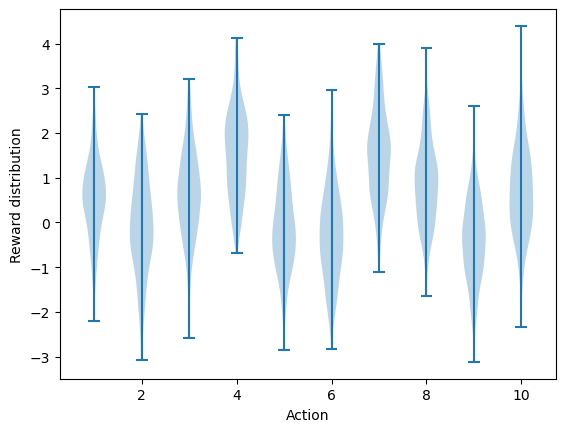

In [10]:
# Set up
np.random.seed(42)

k_arms = 10
n_run = 1000
n_iter = 1000

bandit = Bandit(k_arms=k_arms)

bandit.plot_reward_distribution()

### Epsilon-greedy experiment

In [11]:
eps_space = [0, 0.01, 0.1]

reward_matrix = np.zeros((len(eps_space), n_run, n_iter))
best_action_matrix = np.zeros(reward_matrix.shape)

for i, eps in enumerate(eps_space):
    agent = BanditAgent(epsilon=eps, k_arms=k_arms)
    for j in trange(n_run):
        bandit.reset()
        agent.reset()
        reward_matrix[i, j], best_action_matrix[i, j] = agent.learn(bandit, n_iter=n_iter)

100%|██████████| 1000/1000 [00:38<00:00, 25.65it/s]


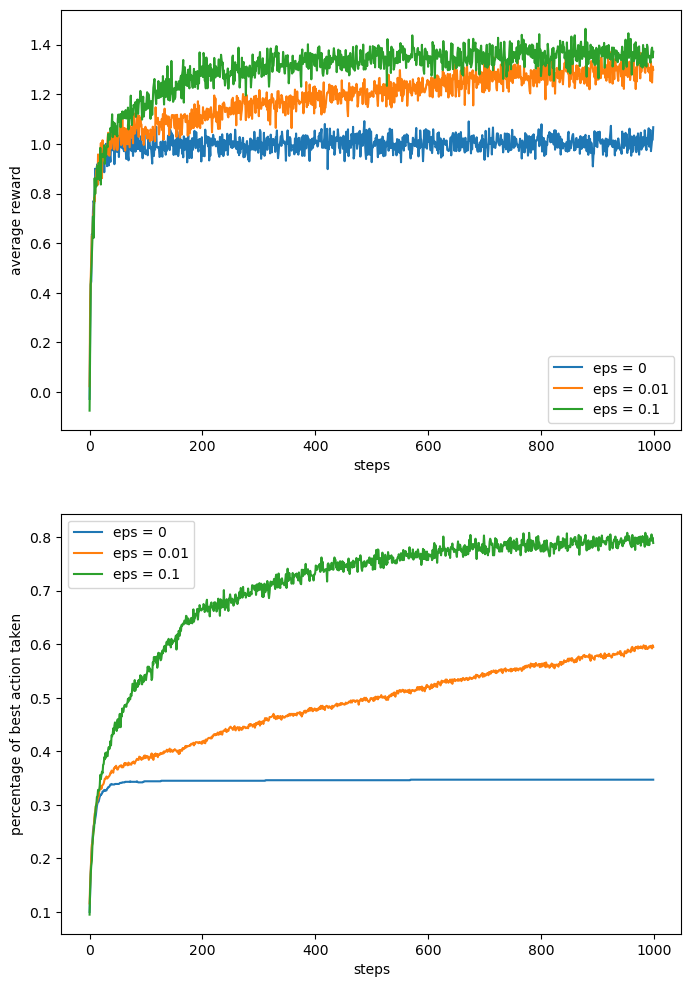

In [12]:
plt.figure(figsize=(8, 12))
plt.subplot(2, 1, 1)
for eps, reward_matrix_for_this_eps in zip(eps_space, reward_matrix):
    plt.plot(reward_matrix_for_this_eps.mean(axis=0), label=f"eps = {eps}")
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()

plt.subplot(2, 1, 2)
for eps, best_action_matrix_for_this_eps in zip(eps_space, best_action_matrix):
    plt.plot(best_action_matrix_for_this_eps.mean(axis=0), label=f"eps = {eps}")
plt.xlabel('steps')
plt.ylabel('percentage of best action taken')
plt.legend()

### UCB experiment

In [13]:
reward_matrix = np.zeros((2, n_run, n_iter))
for i, agent in enumerate([BanditAgent(epsilon=0.1), BanditAgent(UCB_c=2)]):
    for j in trange(n_run):
        bandit.reset()
        agent.reset()
        reward_matrix[i, j], _ = agent.learn(bandit, n_iter=n_iter)

100%|██████████| 1000/1000 [00:54<00:00, 18.34it/s]


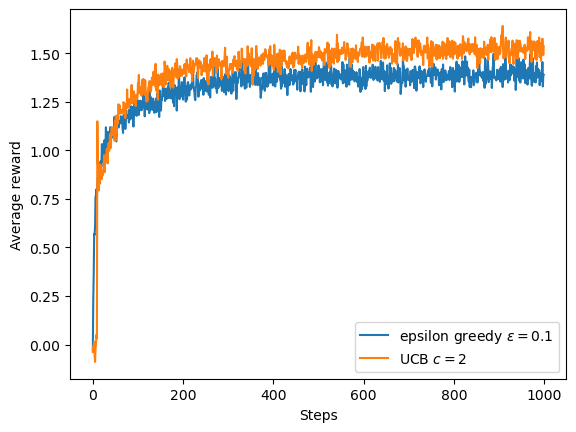

In [14]:
plt.plot(reward_matrix[0].mean(axis=0), label='epsilon greedy $\epsilon = 0.1$')
plt.plot(reward_matrix[1].mean(axis=0), label='UCB $c = 2$')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()

### Gradient Bandit Algorithm experiment

In [15]:
bandit_mean4 = Bandit(k_arms=10, q_true_mean=4)

agents = [
    BanditAgent(k_arms=10, gradient=True, step_size=0.1, use_baseline=True),
    BanditAgent(k_arms=10, gradient=True, step_size=0.1, use_baseline=False),
    BanditAgent(k_arms=10, gradient=True, step_size=0.4, use_baseline=True),
    BanditAgent(k_arms=10, gradient=True, step_size=0.4, use_baseline=False),
]

reward_matrix = np.zeros((len(agents), n_run, n_iter))
best_action_matrix = np.zeros(reward_matrix.shape)

for i, agent in enumerate(agents):
    for j in trange(n_run):
        bandit_mean4.reset()
        agent.reset()
        reward_matrix[i, j], best_action_matrix[i, j] = agent.learn(bandit_mean4, n_iter=n_iter)

100%|██████████| 1000/1000 [00:56<00:00, 17.56it/s]


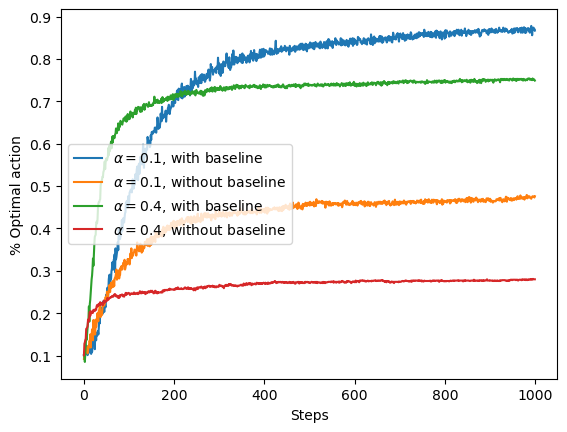

In [16]:
labels = [r'$\alpha = 0.1$, with baseline',
            r'$\alpha = 0.1$, without baseline',
            r'$\alpha = 0.4$, with baseline',
            r'$\alpha = 0.4$, without baseline']

for i in range(len(agents)):
    plt.plot(best_action_matrix[i].mean(axis=0), label=labels[i])
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()
plt.show()

### Q-function Visualization

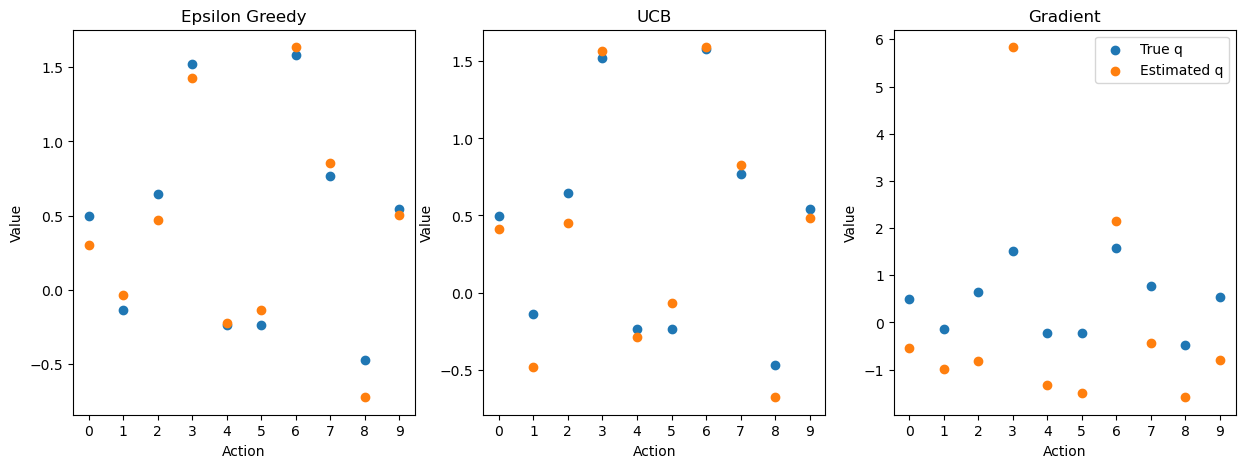

In [26]:
np.random.seed(42)
env = Bandit(k_arms=10)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, title in enumerate(["Epsilon Greedy", "UCB", "Gradient"]):
    if title == "Epsilon Greedy":
        agent = BanditAgent(k_arms=10, epsilon=0.1)
    elif title == "UCB":
        agent = BanditAgent(k_arms=10, UCB_c=2)
    elif title == "Gradient":
        agent = BanditAgent(k_arms=10, gradient=True, step_size=0.1, use_baseline=True)
    
    _, _ = agent.learn(env, n_iter=1000)
    ax[i].scatter(np.arange(10), env.q_true, label="True q", )
    ax[i].scatter(np.arange(10), agent.q_func, label="Estimated q")
    ax[i].set_xticks(np.arange(10))
    ax[i].set_xlabel("Action")
    ax[i].set_ylabel("Value")
    ax[i].set_title(title)
    
plt.legend()
plt.show()
    